# VAERS
[https://github.com/jgarza9788/vaers](https://github.com/jgarza9788/vaers)
---- 


# Disclaimer
**THIS IS NOT MEDICAL ADVICE**   
if you want medical advice please go see your doctor.  

please also read the disclaimer on the VAERS data on their website.  
[VAERS website](https://vaers.hhs.gov/data.html)



# get started
## 1. get the data

download the data from VAERS website  
[link to VAERS website](https://vaers.hhs.gov/data/datasets.html?)

make sure to download the 2020-2022 data
2022VAERSVAX.csv  
2022VAERSSYMPTOMS.csv  
2022VAERSDATA.csv  
2021VAERSVAX.csv  
2021VAERSSYMPTOMS.csv  
2021VAERSDATA.csv  
2020VAERSVAX.csv  
2020VAERSSYMPTOMS.csv  
2020VAERSDATA.csv 


## 2. move and unzip
move the AllVAERSDataCSVS.zip to VAERS folder and unzip it  

## 3. check the files

you should have at least 6 files   
```
.../VAERS/AllVAERSDataCSVS/  
    2022VAERSVAX.csv  
    2022VAERSSYMPTOMS.csv  
    2022VAERSDATA.csv  
    ...
    2020VAERSVAX.csv  
    2020VAERSSYMPTOMS.csv  
    2020VAERSDATA.csv  
```

# THE CODE!

## setup/imports

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import os, sys, re, json
from collections import Counter

# used for graphs/charts
# import plotly.express as px  # too large 
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML # needed for IPYNB


In [2]:
# set pandas options
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## directory variables

DIR (String) : the current directory this file is in  
DATAPATH (String) : the location where the data files are stored

In [3]:

# DIR = os.path.dirname(os.path.realpath(__file__)) #doesn't work due to IPYNB file
DIR = '.' #this works in IPYNB
DATAPATH = os.path.join(DIR,'AllVAERSDataCSVS')

print('DATAPATH: ',DATAPATH)

DATAPATH:  .\AllVAERSDataCSVS


## Saving and Loading JSON files

In [4]:
# LOADING AND SAVING JSON FILES

def load_json(path_to_file):
    """
    loads json from file
    """
    with open(path_to_file, 'r') as f:
        return json.load(f)

def save_json(path_to_file,data):
    """
    writes dict/json to file
    """
    with open(path_to_file, 'w') as f:
        json.dump(data, f,indent=4)

## test
# save_json(os.path.join(DATAPATH,'test.json'),{"HELLO":0})
# print(load_json(os.path.join(DATAPATH,'test.json')))

## processing files

the functions flow will process the csv files into one all_data.json file

In [5]:

def has_covid(text):
    """
    returns 1 or 0 if text has \'COVID\' in it
    """
    if re.search('COVID',text.upper()):
        return 1
    else:
        return 0
        
def compile_files(directory,files):
    """
    compiles/adds/unions multiple csv files together and returns a dataframe
    """
    df = pd.DataFrame()
    for i,f in enumerate(files):
        df0 = pd.read_csv(os.path.join(directory,f),encoding='cp1252',low_memory=False)
        df = pd.concat([df,df0])
    return df

def process_to_one_file():
    """
    processes VAERS data from 2020 - 2023, creates all_data.json, and returns a dataframe
    """
    print('process to one file\n\tthis might take a while...go get a drink☕🍷🍸🍹🍶🍺\n')
    df_data = compile_files(DATAPATH,[
        '2020VAERSDATA.csv',
        '2021VAERSDATA.csv',
        '2022VAERSDATA.csv',
        '2023VAERSDATA.csv'
        ])
    df_vax = compile_files(DATAPATH,[
        '2020VAERSVAX.csv',
        '2021VAERSVAX.csv',
        '2022VAERSVAX.csv',
        '2023VAERSVAX.csv'
        ])
    df_sym = compile_files(DATAPATH,[
        '2020VAERSSYMPTOMS.csv',
        '2021VAERSSYMPTOMS.csv',
        '2022VAERSSYMPTOMS.csv',
        '2023VAERSSYMPTOMS.csv'
        ])

    # print("""
    # symptoms are contained in columns (up to 5 symptoms per event)
    # we must transform these symptoms into a single list for each event
    # """)
    print('dedup-ing Symptoms')
    vid = list(df_sym['VAERS_ID'].unique())

    symptom_columns = [
        'SYMPTOM1',
        'SYMPTOM2',
        'SYMPTOM3',
        'SYMPTOM4',
        'SYMPTOM5'
    ]

    idf_sym = []
    for index,v in enumerate(vid):
        if index%5000 == 0:
            print('{:.2f}'.format(index/len(vid)), end='\r')
        temp = df_sym[df_sym['VAERS_ID'] == v]
        temp = temp.to_dict(orient='records')
        syms = []
        for t in temp:
            for sc in symptom_columns:
                if isinstance(t[sc],str):
                    syms.append(t[sc])
        idf_sym.append({'VAERS_ID':v,'SYMPTOMS':syms})
    df_sym = pd.DataFrame(idf_sym)

    print('merge data')
    df = pd.merge(df_data,df_vax,how='outer',on='VAERS_ID')
    df = df.drop_duplicates(ignore_index = True)
    df = pd.merge(df,df_sym,how='outer',on='VAERS_ID')

    df.reset_index()

    # creating a new column depending if this is the covid vaccine or not
    df['COVID_VAX'] = df['VAX_TYPE'].apply(has_covid)
    df = df[df['COVID_VAX'] == 1]
    # print(len(df))

    #save json file
    json_file = os.path.join(DATAPATH,'all_data.json')
    save_json(json_file,df.to_dict(orient='records'))
    print('saved: ',json_file)

    #save out csv file (not needed), but people might like a csv
    csv_file = os.path.join(DATAPATH,'all_data.csv') 
    df.to_csv(csv_file)
    print('saved: ',csv_file)

    return df


## get data
the below will get data from the files or from all_data.json.

> please note
i am only using 25% of the data below, but you can see the .pdf for how this will look with all the data, or edit and run the notebook on your own.


df (DataFrame) :  contains all the datafrom VAERS files listed below
* .../VAERS/AllVAERSDataCSVS/  
    * 2022VAERSVAX.csv  
    * 2022VAERSSYMPTOMS.csv  
    * 2022VAERSDATA.csv  
    * ...
    * 2020VAERSVAX.csv  
    * 2020VAERSSYMPTOMS.csv  
    * 2020VAERSDATA.csv 

In [6]:
def get_data():
    """
    gets the data and returns a dataframe
    """

    all_data = os.path.join(DATAPATH,'all_data.json')

    if os.path.isfile(all_data):
        print('loading all_data.json (15sec-30sec)')
        df = load_json(all_data)
        df = pd.DataFrame(df)
    else:
        print('processing the 2020-202X files')
        print("""
        .../VAERS/AllVAERSDataCSVS/  
            20??VAERSVAX.csv  
            20??VAERSSYMPTOMS.csv  
            20??VAERSDATA.csv  
        """)
        df = process_to_one_file()

    return df

df = get_data() # this will get all the data
# df = get_data().sample(int(946527 * 0.25)) # only 25% of the data

# assuming null for these is No
df.loc[df['DIED'].isna(),'DIED'] = 'N'
df.loc[df['L_THREAT'].isna(),'L_THREAT'] = 'N'
df.loc[df['ER_VISIT'].isna(),'ER_VISIT'] = 'N'
df.loc[df['HOSPITAL'].isna(),'HOSPITAL'] = 'N'

print('\nloaded {:,} records/rows\n'.format(len(df)))
print('columns:\n',df.columns.to_list())
print('\n\ndf.head(10):\n')
display(df.head(2))

processing the 2020-202X files

        .../VAERS/AllVAERSDataCSVS/  
            20??VAERSVAX.csv  
            20??VAERSSYMPTOMS.csv  
            20??VAERSDATA.csv  
        
process to one file
	this might take a while...go get a drink☕🍷🍸🍹🍶🍺



dedup-ing Symptoms
merge data
saved:  .\AllVAERSDataCSVS\all_data.json
saved:  .\AllVAERSDataCSVS\all_data.csv

loaded 1,060,660 records/rows

columns:
 ['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX', 'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE', 'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMPTOMS', 'COVID_VAX']


df.head(10):



,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOMS,COVID_VAX
46308,902418,12/15/2020,NJ,56.00,56.00,NaN,F,NaN,Patient experienced mild numbness traveling from injection site up and down arm that subsided over 20 minutes.,N,NaN,N,N,N,NaN,NaN,NaN,Y,12/15/2020,12/15/2020,0.00,none,PVT,NaN,latex,none,none,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,none,COVID19,PFIZER\BIONTECH,EH9899,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[Hypoaesthesia, Injection site hypoaesthesia]",1
46327,902440,12/15/2020,AZ,35.00,35.00,NaN,F,NaN,C/O Headache,N,NaN,N,N,N,NaN,NaN,NaN,Y,12/15/2020,12/15/2020,0.00,none,PVT,NaN,NaN,NaN,NaN,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,EH 9899,1,SYR,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),[Headache],1


In [7]:
def print_row(items,column_lengths=[]):
    """
    comes in handly :)
    """
    row = ''
    for index,i in enumerate(items):
        try:
            cl = column_lengths[index]
        except IndexError:
            cl = 20
        row += str(i)[0:cl].ljust(cl)
    print(row)

## gets a list of symptoms

df_symptoms (DataFrame) : a list of all the symtoms and the counts of each 
all_symptoms (list): a list of all the symtoms and the counts of each 

**note:**   
symptoms might be medical jargon or plain english  
i.e. "RASH","ERYTHEMA", and "ITCHY RED SKIN"   
would be reported as different items (for now)

**note:**  
the counts/percentages below are of the symptoms.  
and one adverse reaction can have multiple symptoms.

In [8]:
def get_symptom_list(df,column='SYMPTOMS'):
    """
    returns a list of symptoms for the dataframe
    """
    s = df[column].to_list()
    l = []
    for i in s:
        try:
            for j in i:
                if str(j) == 'nan':
                    pass
                else:
                    l.append(str(j).upper())
        except:
            pass
    return l

all_symptoms =  get_symptom_list(df,'SYMPTOMS')
symptoms_count = len(all_symptoms)
all_symptoms = Counter(all_symptoms).most_common()

df_symptoms = pd.DataFrame(all_symptoms,columns=['SYMPTOM','COUNT'])
df_symptoms['PERCENT'] = (df_symptoms['COUNT']/symptoms_count)*100

file_name = os.path.join(DATAPATH,'symptoms.csv')
df_symptoms.to_csv(file_name)
print('saved: ',file_name)

topX = 50
print('below are the top {} symptoms'.format(topX))
display(df_symptoms.head(topX))



saved:  .\AllVAERSDataCSVS\symptoms.csv
below are the top 50 symptoms


,SYMPTOM,COUNT,PERCENT
0,HEADACHE,158297,3.48
1,PYREXIA,138507,3.04
2,FATIGUE,138074,3.03
3,PAIN,114083,2.51
4,COVID-19,112270,2.47
5,CHILLS,110798,2.43
6,NAUSEA,86364,1.90
7,PAIN IN EXTREMITY,84990,1.87
8,DIZZINESS,83903,1.84
9,SARS-COV-2 TEST POSITIVE,76103,1.67


c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'the top 50 Symptoms (by most frequent)')]

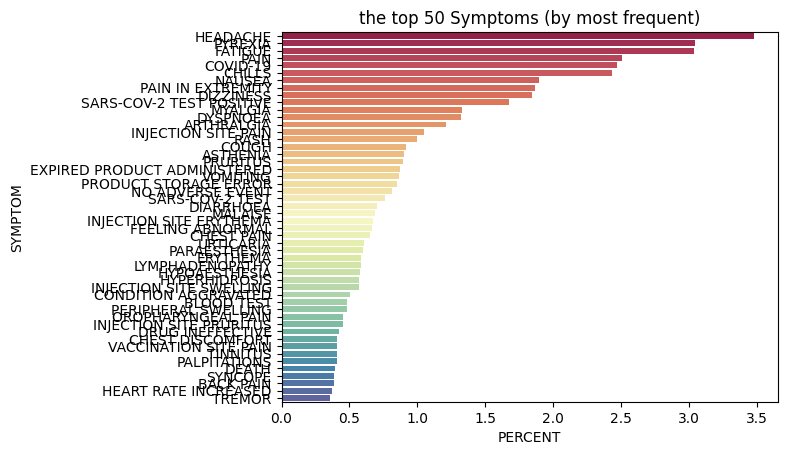

In [9]:

# lets put it in a histogram!

# fig = px.histogram(
#     df_symptoms.head(topX), 
#     x="SYMPTOM", 
#     y="PERCENT", 
#     # marginal="rug", # can be `box`, `violin`
#      hover_data=df_symptoms.head(topX).columns
#     )
# fig.show()

sns.barplot(
    data=df_symptoms.head(topX),
    x="PERCENT", 
    y="SYMPTOM",
    # hue="PERCENT"
    palette = "Spectral"
    ).set(title=f'the top {topX} Symptoms (by most frequent)')


## break down functions...
these functions will help me breakdown the data

### break_down_columns

In [10]:

def break_down_columns(idf,column):
    """
    shows what values there are for a given column (with counts and percent)
    """
    print('\nbreak down of {0}'.format(column))
    idf = pd.DataFrame(idf[column])
    idf = idf.fillna('nan')

    result = []

    l = list(idf[column].unique())
    for i in l:
        df0 = idf[idf[column]==i]
        result.append({'column':column,'value':i,'count':len(df0),'percent':(len(df0)/len(idf))*100})
    
    result = pd.DataFrame(result)
    display(result)
    return result

# test
# break_down_columns(df,'DIED')



### break_down_buckets

In [11]:


def break_down_buckets(idf,column,buckets,message='',nan_value=-1):
    """
    breaks a column down into buckets/bins
    """
    idf = idf.fillna(nan_value)

    print('',message,'\ncolumn: ',column, '\nbuckets: ', buckets)
    
    idf = pd.DataFrame(idf[column])
    idf['bucket'] = pd.cut(idf[column], bins=buckets)
    idf = idf.groupby(by='bucket').count()
    idf['percent'] = (idf[column]/idf[column].sum())*100
    idf['percent'] = idf['percent'].round(2)
    display(idf)

    return idf

#test
# break_down_buckets(df,'AGE_YRS',[-1,0,15,25,35,45,55,65,75,85,500])


## Additional Numbers

~~these numbers are **not** part of the vaers data,  
however they are important to analyzing the data~~

~~vaxx (int) : the number of vaccinated (1 or more shots) US citizens according to a quick google search (on 8/3/2021)~~

~~**google no longer shows partially vaxxed**  so we are using the **Total doses given** number  
"Total doses given" shows the number of vaccine doses given to people. Since some vaccines require more than 1 dose, the number of fully vaccinated people is likely lower. "People fully vaccinated" shows how many people have received the full amount of doses for the COVID-19 vaccine.  ~~

~~This number was updated on 06/28/2022~~

~~full_vaxx (int) : the number of vaccinated (2 or more shots) US citizens according to a quick google search (on 06/28/2022)~~

~~the numbers were taken from https://usafacts.org/visualizations/covid-vaccine-tracker-states
on 11/18/2022~~

the numbers were taken from https://usafacts.org/visualizations/covid-vaccine-tracker-states
on 9/10/2023

In [12]:
vaxx = 270_227_181 + 230_637_348
full_vaxx = 230_637_348

In [13]:
#only death vaers
df_death = df[df['DIED']=='Y']

## Analyzing the df (all_data.json)
this is just a generic break down of the data

df_death (DataFrame) :  adverse reactions that resulted in a death

### DIED column


break down of DIED


,column,value,count,percent
0,DIED,N,1038550,97.92
1,DIED,Y,22110,2.08



-------------------------



c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Died vs not-Died')]

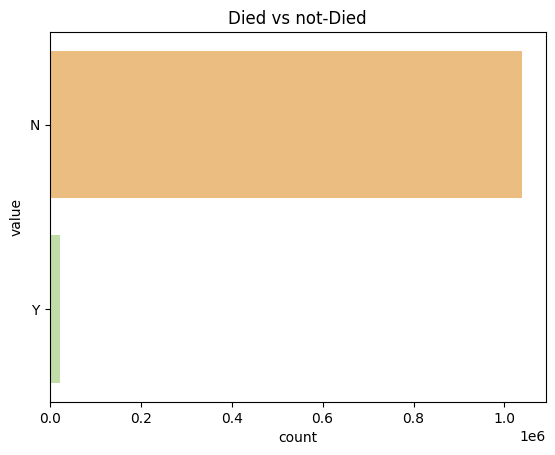

In [14]:

temp = break_down_columns(df,'DIED')
print('\n' + '-'*25 + '\n')


# fig = px.pie(
#     temp, 
#     values='count', 
#     names='value', 
#     title='Death as Symptoms from Vaccine',
#     # hover_data = temp.columns
#     )
# fig.show()

sns.barplot(
    data=temp,
    x="count", 
    y="value",
    # hue="PERCENT"
    palette = "Spectral"
    ).set(title='Died vs not-Died')


### ER_VISIT column

did the adverse reaction result in an ER Visit

break down of ER_VISIT


,column,value,count,percent
0,ER_VISIT,N,1060514,99.99
1,ER_VISIT,Y,146,0.01



-------------------------



c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Did the they need the ER?')]

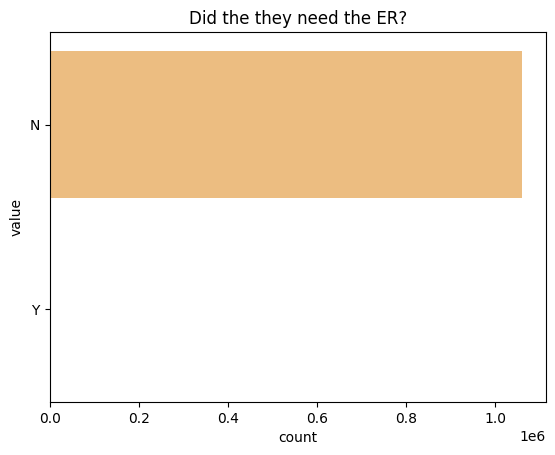

In [15]:

print('did the adverse reaction result in an ER Visit')
temp = break_down_columns(df,'ER_VISIT')
print('\n' + '-'*25 + '\n')

# temp.plot.bar(title='ER_VISIT',x='value',y='count',rot=0,figsize=(5,5),width=0.25,fontsize=18)
# temp = temp.set_index('value')
# temp.plot.pie(title='ER_VISIT',y='percent',figsize=(5, 5),autopct='%.2f',fontsize=18)

# fig = px.bar(
#     temp, 
#      x='count', 
#      y='value',
#     title='Did the they need the ER?',
#     )
# fig.show()

sns.barplot(
    data=temp,
    x="count", 
    y="value",
    # hue="PERCENT"
    palette = "Spectral"
    ).set(title='Did the they need the ER?')

### L_THREAT column

Life Threatening/Leathal Threat

break down of L_THREAT


,column,value,count,percent
0,L_THREAT,N,1043787,98.41
1,L_THREAT,Y,16873,1.59



-------------------------



c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'was this a lethal threat?')]

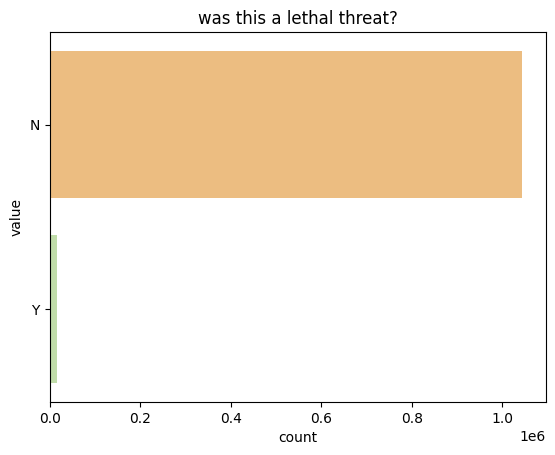

In [16]:

print('Life Threatening/Leathal Threat')
temp = break_down_columns(df,'L_THREAT')
print('\n' + '-'*25 + '\n')

# temp.plot.bar(title='L_THREAT',x='value',y='count',rot=0,figsize=(5,5),width=0.25,fontsize=18)
# temp = temp.set_index('value')
# temp.plot.pie(title='L_THREAT',y='percent',figsize=(5, 5),autopct='%.2f',fontsize=18)

# fig = px.bar(
#     temp, 
#     x='count', 
#     y='value',
#     title="was this a lethal threat?"
#     )
# fig.show()

sns.barplot(
    data=temp,
    x="count", 
    y="value",
    # hue="PERCENT"
    palette = "Spectral"
    ).set(title='was this a lethal threat?')

### RECOVD column

did the patient recover?

break down of RECOVD


,column,value,count,percent
0,RECOVD,Y,320796,30.24
1,RECOVD,N,339448,32.00
2,RECOVD,U,259390,24.46
3,RECOVD,nan,141026,13.30



-------------------------



<Axes: title={'center': 'RECOVD'}, ylabel='percent'>

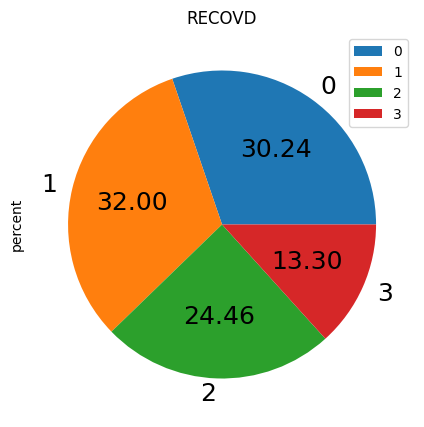

In [17]:

print('did the patient recover?')
temp = break_down_columns(df,'RECOVD')

print('\n' + '-'*25 + '\n')

# temp.plot.bar(title='RECOVD',x='value',y='count',rot=0,figsize=(5,5),width=0.25,fontsize=18)
# temp = temp.set_index('value')
temp.plot.pie(title='RECOVD',y='percent',figsize=(5, 5),autopct='%.2f',fontsize=18)

# fig = px.bar(
#     temp, 
#     x='count', 
#     y='value',
#     title="Did the patient recover? (Y=yes, N=no, U=unknown, nan=N/A )"
#     )
# fig.show()


### the Age of the patient

the Age of the patient
  
column:  AGE_YRS 
buckets:  [0, 15, 25, 35, 45, 55, 65, 75, 85, 500]


C:\Users\JGarza\AppData\Local\Temp\ipykernel_9980\4231830367.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idf = idf.groupby(by='bucket').count()


,AGE_YRS,percent
bucket,,
"(0, 15]",45824,4.79
"(15, 25]",74452,7.78
"(25, 35]",121851,12.73
"(35, 45]",144225,15.07
"(45, 55]",150044,15.68
"(55, 65]",167417,17.49
"(65, 75]",151579,15.84
"(75, 85]",74810,7.82
"(85, 500]",26849,2.81



-------------------------



c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


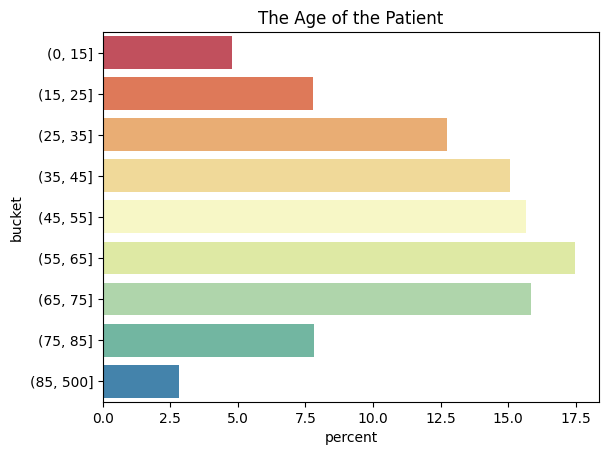

In [18]:


print('the Age of the patient')
temp = break_down_buckets(df,'AGE_YRS',[0,15,25,35,45,55,65,75,85,500])
temp = temp.reset_index()
temp["bucket"] = temp["bucket"].astype(str)

# temp = temp.reset_index()
# temp.plot.bar(title='AGE_YRS',x='bucket',y='AGE_YRS',rot=90,figsize=(5,5),width=0.25,fontsize=18)
# # temp.plot.bar(title='AGE_YRS',x='bucket',y='percent',rot=90,figsize=(5,5),width=0.25,fontsize=18)

# fig = px.bar(
#     temp, 
#     x='percent', 
#     y='bucket',
#     title="The Age of the Patient"
#     )
# fig.show()

sns.barplot(
    data=temp,
    x="percent", 
    y="bucket",
    palette = "Spectral"
    ).set(title='The Age of the Patient')

print('\n' + '-'*25 + '\n')



 ***deaths only*** 
column:  AGE_YRS 
buckets:  [0, 15, 25, 35, 45, 55, 65, 75, 85, 500]


C:\Users\JGarza\AppData\Local\Temp\ipykernel_9980\4231830367.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idf = idf.groupby(by='bucket').count()


,AGE_YRS,percent
bucket,,
"(0, 15]",65,0.32
"(15, 25]",155,0.76
"(25, 35]",265,1.30
"(35, 45]",491,2.40
"(45, 55]",1047,5.13
"(55, 65]",2772,13.57
"(65, 75]",5265,25.78
"(75, 85]",5904,28.91
"(85, 500]",4456,21.82


c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):



-------------------------



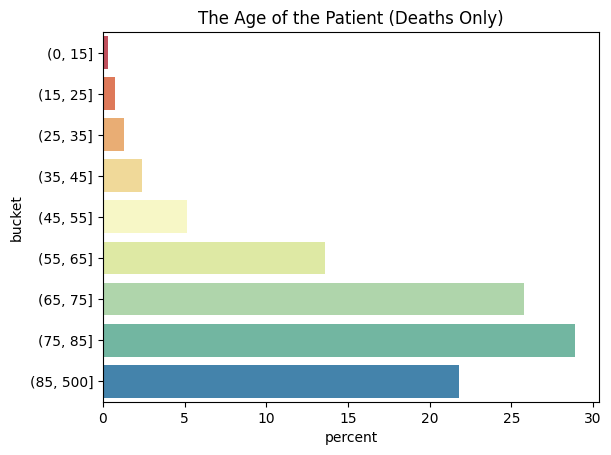

In [19]:
temp = break_down_buckets(df_death,'AGE_YRS',[0,15,25,35,45,55,65,75,85,500],message='***deaths only***')
temp = temp.reset_index()
temp["bucket"] = temp["bucket"].astype(str)

# temp = temp.reset_index()
# temp.plot.bar(title='AGE_YRS (death only)',x='bucket',y='AGE_YRS',rot=90,figsize=(5,5),width=0.25,fontsize=18)
# # temp.plot.bar(title='AGE_YRS (death only)',x='bucket',y='percent',rot=90,figsize=(5,5),width=0.25,fontsize=18)

# fig = px.bar(
#     temp, 
#     x='percent', 
#     y='bucket',
#     title="The Age of the Patient"
#     )
# fig.show()

sns.barplot(
    data=temp,
    x="percent", 
    y="bucket",
    palette = "Spectral"
    ).set(title='The Age of the Patient (Deaths Only)')

print('\n' + '-'*25 + '\n')


### the number of days between the vaccine and the adverse rection

the number of days between the vaccine and the adverse rection
  
column:  NUMDAYS 
buckets:  [0, 1, 5, 10, 20, 30, 40, 50, 60]


C:\Users\JGarza\AppData\Local\Temp\ipykernel_9980\4231830367.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idf = idf.groupby(by='bucket').count()


,NUMDAYS,percent
bucket,,
"(0, 1]",150580,37.09
"(1, 5]",90093,22.19
"(5, 10]",63874,15.73
"(10, 20]",40664,10.02
"(20, 30]",30280,7.46
"(30, 40]",15302,3.77
"(40, 50]",8336,2.05
"(50, 60]",6835,1.68



-------------------------



c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


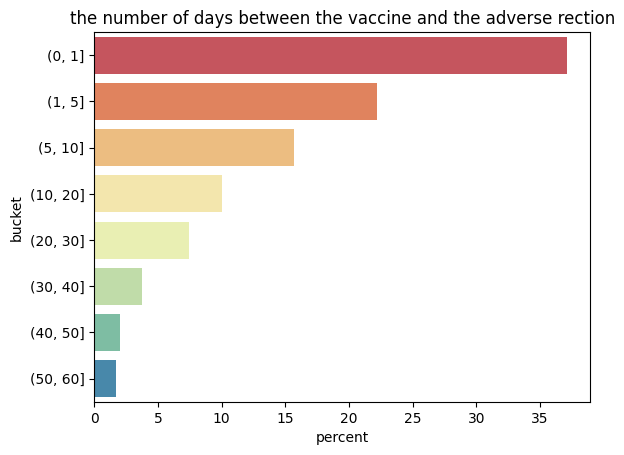

In [20]:


print('the number of days between the vaccine and the adverse rection')
temp = break_down_buckets(df,'NUMDAYS',[0,1,5,10,20,30,40,50,60])
temp = temp.reset_index()
temp["bucket"] = temp["bucket"].astype(str)

# temp.plot.barh(title='NUMDAYS',x='bucket',y='NUMDAYS',rot=0,figsize=(10,5),width=0.25,fontsize=18)
# # temp.plot.bar(title='AGE_YRS',x='bucket',y='percent',rot=90,figsize=(5,5),width=0.25,fontsize=18)

# fig = px.bar(
#     temp, 
#     x='percent', 
#     y='bucket',
#     title="the number of days between the vaccine and the adverse rection"
#     )
# fig.show()

sns.barplot(
    data=temp,
    x="percent", 
    y="bucket",
    palette = "Spectral"
    ).set(title='the number of days between the vaccine and the adverse rection')

print('\n' + '-'*25 + '\n')




 ***deaths only*** 
column:  NUMDAYS 
buckets:  [0, 1, 5, 10, 20, 30, 40, 50, 60]


C:\Users\JGarza\AppData\Local\Temp\ipykernel_9980\4231830367.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idf = idf.groupby(by='bucket').count()


,NUMDAYS,percent
bucket,,
"(0, 1]",1322,16.70
"(1, 5]",1663,21.01
"(5, 10]",1049,13.25
"(10, 20]",1380,17.43
"(20, 30]",1034,13.06
"(30, 40]",626,7.91
"(40, 50]",430,5.43
"(50, 60]",412,5.20


c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):



-------------------------



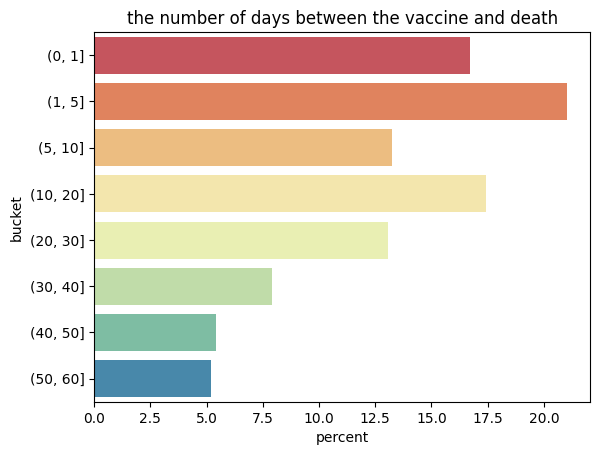

In [21]:
temp = break_down_buckets(df_death,'NUMDAYS',[0,1,5,10,20,30,40,50,60],message='***deaths only***')
temp = temp.reset_index()
temp["bucket"] = temp["bucket"].astype(str)

# temp.plot.barh(title='NUMDAYS (deaths only)',x='bucket',y='NUMDAYS',rot=0,figsize=(10,5),width=0.25,fontsize=18)
# temp.plot.bar(title='AGE_YRS',x='bucket',y='percent',rot=90,figsize=(5,5),width=0.25,fontsize=18)

# fig = px.bar(
#     temp, 
#     x='percent', 
#     y='bucket',
#     title="the number of days between the vaccine and death"
#     )
# fig.show()

sns.barplot(
    data=temp,
    x="percent", 
    y="bucket",
    palette = "Spectral"
    ).set(title='the number of days between the vaccine and death')

print('\n' + '-'*25 + '\n')

c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\JGarza\pythons\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

[Text(0.5, 1.0, 'showing number of days between vaccine and adverse reaction ( only 10 days or less, broke out death into other color)')]

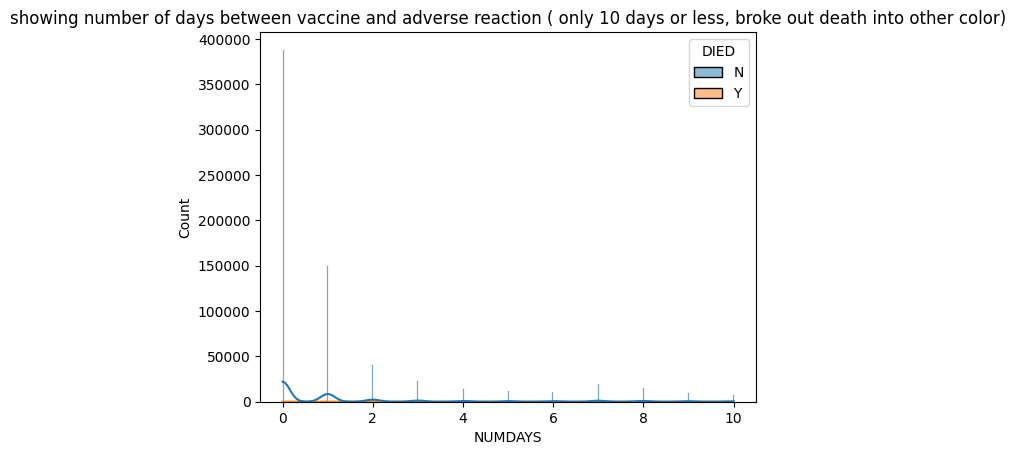

In [22]:
temp = df[df['NUMDAYS'] <= 10]

sns.histplot(
    data=temp, 
    x="NUMDAYS",
    hue='DIED', 
    kde=True
    ).set(title='showing number of days between vaccine and adverse reaction ( only 10 days or less, broke out death into other color)')

# fig = px.histogram(
#     temp, 
#     x="NUMDAYS",
#     color='DIED',
#     marginal="violin",
#     hover_data=temp.columns,
#     title="showing number of days between vaccine and adverse reaction ( only 25 days or less, 25% sample,broke out death into other color)"
#     )
# fig.update_layout(barmode='overlay')
# fig.update_traces(opacity=0.75)
# fig.show()

### break down of the VAX_NAME column

In [23]:

print('break down of the VAX_NAME column')
df_VN = break_down_columns(df,'VAX_NAME')

print('\n***deaths only***')
df_DVN = break_down_columns(df_death,'VAX_NAME')

# df_CVN = df_VN.join(df_DVN[['value','count']],on='value')
df_DVN = df_DVN.rename(columns={"count": "death_count"})


print('calculating the death ratio ( death_count / count )')
df_CVN = pd.concat([df_VN,df_DVN],keys=['value'],join="inner",axis=1)

df_CVN = pd.merge(df_VN,df_DVN,on=['value'])
df_CVN = df_CVN.drop(columns=['percent_x','percent_y','column_y']) 
df_CVN = df_CVN.rename(columns={"column_x": "column"})
df_CVN['death_ratio'] = df_CVN['death_count'] / df_CVN['count']
df_CVN['death_percent'] = df_CVN['death_ratio']*100

display(df_CVN)



print('\n' + '-'*25 + '\n')

break down of the VAX_NAME column

break down of VAX_NAME


,column,value,count,percent
0,VAX_NAME,COVID19 (COVID19 (PFIZER-BIONTECH)),474706,44.76
1,VAX_NAME,COVID19 (COVID19 (UNKNOWN)),7104,0.67
2,VAX_NAME,COVID19 (COVID19 (MODERNA)),465382,43.88
3,VAX_NAME,COVID19 (COVID19 (MODERNA BIVALENT)),16851,1.59
4,VAX_NAME,COVID19 (COVID19 (PFIZER-BIONTECH BIVALENT)),23066,2.17
5,VAX_NAME,COVID19 (COVID19 (JANSSEN)),73130,6.89
6,VAX_NAME,COVID19 (COVID19 (NOVAVAX)),421,0.04



***deaths only***

break down of VAX_NAME


,column,value,count,percent
0,VAX_NAME,COVID19 (COVID19 (MODERNA)),9552,43.20
1,VAX_NAME,COVID19 (COVID19 (PFIZER-BIONTECH)),10195,46.11
2,VAX_NAME,COVID19 (COVID19 (UNKNOWN)),79,0.36
3,VAX_NAME,COVID19 (COVID19 (JANSSEN)),1906,8.62
4,VAX_NAME,COVID19 (COVID19 (PFIZER-BIONTECH BIVALENT)),214,0.97
5,VAX_NAME,COVID19 (COVID19 (MODERNA BIVALENT)),160,0.72
6,VAX_NAME,COVID19 (COVID19 (NOVAVAX)),4,0.02


calculating the death ratio ( death_count / count )


C:\Users\JGarza\AppData\Local\Temp\ipykernel_9980\2074247858.py:12: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  df_CVN = pd.concat([df_VN,df_DVN],keys=['value'],join="inner",axis=1)


,column,value,count,death_count,death_ratio,death_percent
0,VAX_NAME,COVID19 (COVID19 (PFIZER-BIONTECH)),474706,10195,0.02,2.15
1,VAX_NAME,COVID19 (COVID19 (UNKNOWN)),7104,79,0.01,1.11
2,VAX_NAME,COVID19 (COVID19 (MODERNA)),465382,9552,0.02,2.05
3,VAX_NAME,COVID19 (COVID19 (MODERNA BIVALENT)),16851,160,0.01,0.95
4,VAX_NAME,COVID19 (COVID19 (PFIZER-BIONTECH BIVALENT)),23066,214,0.01,0.93
5,VAX_NAME,COVID19 (COVID19 (JANSSEN)),73130,1906,0.03,2.61
6,VAX_NAME,COVID19 (COVID19 (NOVAVAX)),421,4,0.01,0.95



-------------------------



## Approximating actual adverse reaction numbers

VAERS only contains reported data and  
*'...fewer than 1% of vaccine adverse events are reported.'*  
Source: 
https://digital.ahrq.gov/sites/default/files/docs/publication/r18hs017045-lazarus-final-report-2011.pdf (page 6)


we will me multiplying the counts by 80 and 120,  
in order to get an approzimate min and max of what the numbers might actually be.  



In [24]:

def print_percent(vmin,vmax,label0,vcount,label1):
    """
    vmin: vaers min
    vmax: vaers max
    label0: vaers label
    vcount: vaxxed count
    label1: vaxxed label
    """
    print(
        '( {label0} / {lavel1} ) * 100\n'.format(
            label0=label0,
            lavel1=label1
            ),
        'min: ( {0:,} / {1:,} ) * 100 \n'.format(vmin,vcount),
        'max: ( {0:,} / {1:,} ) * 100 \n'.format(vmax,vcount),
        '{:.2f} %'.format((vmin/vcount)*100),
        '-',
        '{:.2f} %'.format((vmax/vcount)*100),
        '\n'
        )   

print_percent(
    len(df)*80,
    len(df)*120,
    'approx adverse reactions',
    vaxx,
    'vaxxed [1 or more shots]'
    )

print_percent(
    len(df_death)*80,
    len(df_death)*120,
    'approx adverse deaths',
    vaxx,
    'vaxxed [1 or more shots]'
    )

df_nrecovd = df[df['RECOVD']=='N']
print_percent(
    len(df_nrecovd)*80,
    len(df_nrecovd)*120,
    'approx no recovery',
    vaxx,
    'vaxxed [1 or more shots]'
    )

df_urecovd = df[df['RECOVD']=='U']
print_percent(
    (len(df_nrecovd) + (len(df_urecovd)*0.5))*80,
    (len(df_nrecovd) + (len(df_urecovd)*0.5))*120,
    'approx no recovery + (50% of unknowns)',
    vaxx,
    'vaxxed [1 or more shots]'
    )


( approx adverse reactions / vaxxed [1 or more shots] ) * 100
 min: ( 84,852,800 / 500,864,529 ) * 100 
 max: ( 127,279,200 / 500,864,529 ) * 100 
 16.94 % - 25.41 % 

( approx adverse deaths / vaxxed [1 or more shots] ) * 100
 min: ( 1,768,800 / 500,864,529 ) * 100 
 max: ( 2,653,200 / 500,864,529 ) * 100 
 0.35 % - 0.53 % 

( approx no recovery / vaxxed [1 or more shots] ) * 100
 min: ( 27,155,840 / 500,864,529 ) * 100 
 max: ( 40,733,760 / 500,864,529 ) * 100 
 5.42 % - 8.13 % 

( approx no recovery + (50% of unknowns) / vaxxed [1 or more shots] ) * 100
 min: ( 37,531,440.0 / 500,864,529 ) * 100 
 max: ( 56,297,160.0 / 500,864,529 ) * 100 
 7.49 % - 11.24 % 



## Women's Reproductive Symptoms

Why?
I have women in my life that were curious about this.

WRS_list (list) :  a list of symptoms that effect or could cause effects to a women's reproductive system  
df_WRS (DataFrame) :  a dataframe that contains VAERS events that have at least 1 of the WRS symptoms

In [25]:
def symptom_filter_search(idf, search_list):
    """
    returns a dataframe pf vaers events where the patient 
    has had 1 or more of the symptoms on the list
    """
    print('this could take between 20sec-60sec')

    data = idf.to_dict(orient='records')

    search_list = [i.upper() for i in search_list]
    
    results = []
    for index,d in enumerate(data):
        # if index%5000 == 0:
        #     print('{:.2f}'.format(index/len(data)))
        try:
            d['SYMPTOMS'] = [i.upper() for i in d['SYMPTOMS'] if isinstance(i, str)]
        
            symptom_match = list(set(d['SYMPTOMS']) & set(search_list))
            d['SYMPTOMS_MATCH'] = symptom_match
            d['SYMPTOMS_MATCH_LENGTH'] = len(symptom_match)
            if len(symptom_match) > 0:
                results.append(d)
        except:
            pass

    return pd.DataFrame(results)

In [26]:
WRS_list = [
    'Intermenstrual bleeding',
    'Menopause',
    'Heavy menstrual bleeding',
    'dysmenorrhoea',
    'ABNORMAL UTERINE BLEEDING',
    'MATERNAL EXPOSURE BEFORE PREGNANCY',
    'MENSTRUATION IRREGULAR',
    'Oligomenorrhea',
    'OLIGOMENORRHOEA',
    'POLYMENORRHOEA',
    'MENSTRUAL DISORDER', 
    'OLIGOMENORRHOEA',
    'ANOVULATORY CYCLE',
    'OVULATION DELAYED',
    'BACTERIAL VAGINOSIS',
    'GYNAECOLOGICAL EXAMINATION ABNORMAL',
    'OVARIAN CYST',
    'BIOPSY UTERUS',
    'UTERINE LEIOMYOMA',
    'HOT FLUSH',
    'BREAST TENDERNESS',
    'BREAST SWELLING',
    'BREAST PAIN',
    'VAGINAL HAEMORRHAGE'
    ]
WRS_list = [i.upper() for i in WRS_list]

In [27]:
df_WRS = symptom_filter_search(df,WRS_list)

print('df_WRS.head(5)')
display(df_WRS.head(5))


this could take between 20sec-60sec
df_WRS.head(5)


,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOMS,COVID_VAX,SYMPTOMS_MATCH,SYMPTOMS_MATCH_LENGTH
0,902796,12/16/2020,TX,34.00,34.00,NaN,F,NaN,"I inserted my NuvaRing birth control on 12/14/2020. I have the Covid19 vaccine on 12/15/2020 at about 8:30am. The injection site was mildly sore and that continued into the next day. I woke up on 12/16/2020 feeling a little off and it progressed throughout the day. I felt a headache that I knew was turning into a migraine, threw up a few times (this is normal for me when I get migraines), and started having hot flashes. My temperature never went above 98. After sleeping a few hours and taking some Excedrin migraine I was feeling much better, though still a little sickly, by 4pm. I really think this is due to my migraines (which I get roughly once a month) even though it was a day later than normal.",N,NaN,N,N,N,NaN,NaN,NaN,Y,12/15/2020,12/16/2020,1.00,NaN,PVT,NaN,Methylphenidate Citalopram Buspirone Tylenol,NaN,"I normally get a migraine a day or two after I insert my NuvaRing. I inserted it on Monday, 12/14/2020 and I think all my symptoms are related to that rather than the vaccination.",NaN,NaN,2,12/16/2020,NaN,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,EH9899,1,SYR,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[CONDITION AGGRAVATED, FEELING ABNORMAL, HOT FLUSH, INJECTION SITE PAIN, MALAISE, MIGRAINE, VOMITING]",1,[HOT FLUSH],1
1,903202,12/17/2020,NE,41.00,41.00,NaN,F,NaN,"Severe dizzy spell about 5-10 following injection, helped to the floor, this lasted approximately 30-40 minutes after start of symptom. Hot flashes and visual disturbance lasting into following day.",N,NaN,N,N,N,NaN,NaN,NaN,Y,12/16/2020,12/16/2020,0.00,NaN,OTH,NaN,"Buspar, propranolol, escitalopram, crestor, amitriptyline, baby aspirin, super B complex, black elderberry, calcium/mag/zinc supplement, CoQ10, vitamin D3, biotin, antarctic Krill oil, women's multivitamin, tart cherry supplement, ibupr",NaN,"Migraine, anxiety, depression, hyperlipidemia",NaN,NaN,2,12/17/2020,NaN,NaN,NaN,Aimovig,COVID19,PFIZER\BIONTECH,EH9899,1,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[DIZZINESS, HOT FLUSH, VISUAL IMPAIRMENT]",1,[HOT FLUSH],1
2,903247,12/17/2020,AR,42.00,42.00,NaN,F,NaN,I had arm pain. Yesterday I had a hot flash with throwing up and diarrhea.,N,NaN,N,N,N,NaN,NaN,NaN,N,12/15/2020,12/16/2020,1.00,No,UNK,NaN,"I take Estradiol, Metprolol, Lexapro, Multivitamin, Calcium, Ambien, Benadryl, Melatonin",No,I have SVT,NaN,vsafe,2,12/17/2020,NaN,NaN,NaN,I am allergic to Sulphur,COVID19,PFIZER\BIONTECH,NaN,UNK,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[DIARRHOEA, HOT FLUSH, PAIN IN EXTREMITY, VOMITING]",1,[HOT FLUSH],1
3,903329,12/18/2020,PA,46.00,46.00,NaN,F,NaN,"hot flushing feeling, light headed, legs heavy gave patient a chair to sit and candy symptoms resolved by 11:36",N,NaN,N,N,N,NaN,NaN,NaN,Y,12/17/2020,12/17/2020,0.00,NaN,PVT,NaN,NaN,NaN,NaN,NaN,NaN,2,12/18/2020,NaN,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,EK5730,1,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[DIZZINESS, HOT FLUSH, LIMB DISCOMFORT]",1,[HOT FLUSH],1
4,903345,12/18/2020,VA,37.00,37.00,NaN,F,NaN,"Right arm soreness, headache, hot flashes.",N,NaN,N,N,N,NaN,NaN,NaN,Y,12/16/2020,12/17/2020,1.00,NaN,WRK,NaN,NaN,NaN,NaN,NaN,NaN,2,12/18/2020,NaN,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,NaN,UNK,NaN,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),"[HEADACHE, HOT FLUSH, PAIN IN EXTREMITY]",1,[HOT FLUSH],1


### What percent of women experienced WRS during their adverse reactions?

(women experiencing reproductive symptoms ➗ number of women in VAERS data) * 100

WRS_ratio (float) : count WRS / count VAERS

In [28]:
#get count of women in VAERS data 

w_df = df[df['SEX']=='F']
u_df = df[df['SEX']=='U']
w_count = len(w_df) + (len(u_df)/2) #half of unknown

WRS_ratio = (len(df_WRS)/w_count)

print( '{:.2f} %'.format(WRS_ratio*100))

file_name = os.path.join(DATAPATH,'WRS.csv')
df_WRS.to_csv(file_name)

print('VAERS records of women experiencing reproductive symptoms have been saved.')
print('saved: ',file_name)



3.22 %
VAERS records of women experiencing reproductive symptoms have been saved.
saved:  .\AllVAERSDataCSVS\WRS.csv


### Approximate the number of WRS in reality

since '~63% of the people who are vaccinated are women'
source: https://www.statista.com/statistics/1212103/share-of-persons-initiating-covid-vaccinations-by-gender-us-first-month/

we will be multiplying the total number of people vaccinated (1 or more shots) by 0.63 to get the count of women vaccinated.

women_vaxx (float) : an approximate number of women who have had 1 or more vaccine shot.

>note: 0.63 is an estimate, and the actual could be somewhere between 0.50 and 0.70

In [29]:
women_vaxx = vaxx * 0.63
print(women_vaxx)

315544653.27


### approximate real WRS
if we assume that the VAERS data is a random sample (or close to it)  
then the ratio of WRS systems should be the same...

and thus we can get an approximate number of women that would be experiencing reproductive symptoms by multiplying the number of vaxxed women by the ratio

WRS (float) : the approximate number of actual women experiencing reproductive symptoms
min_WRS (float) : WRS * 0.80
max_WRS (float) : WRS * 1.20

In [30]:
WRS = women_vaxx * WRS_ratio
min_WRS = WRS*0.80
max_WRS = WRS*1.20

In [31]:
cl = [35,5,15]
print_row(['total vaxxed (1 or more)','---','{:,.2f}'.format(vaxx)],column_lengths=cl)
print_row(['women vaxxed ~0.63%','---','{:,.2f}'.format(women_vaxx)],column_lengths=cl)
print_row(['repro sympt / women count','---','{:,.4f}'.format(WRS_ratio)],column_lengths=cl)
print_row(['(repro sympt / women count) * 100','---','{:,.2f} %'.format(WRS_ratio*100)],column_lengths=cl)
print_row(['women w/ repro symptoms','---','{:,.2f}'.format(WRS)],column_lengths=cl)
print_row(['min women w/ repro symptoms','---','{:,.2f}'.format(min_WRS)],column_lengths=cl)
print_row(['max women w/ repro symptoms','---','{:,.2f}'.format(max_WRS)],column_lengths=cl)


total vaxxed (1 or more)           ---  500,864,529.00 
women vaxxed ~0.63%                ---  315,544,653.27 
repro sympt / women count          ---  0.0322         
(repro sympt / women count) * 100  ---  3.22 %         
women w/ repro symptoms            ---  10,147,648.30  
min women w/ repro symptoms        ---  8,118,118.64   
max women w/ repro symptoms        ---  12,177,177.96  


### Where do the WRS (Women reproductive symptoms) rank against with the other symptoms?

In [32]:
temp = []

for index,i in enumerate(all_symptoms):
    if i[0].upper() in WRS_list:
        temp.append(
            {
                'index':index,
                'symptoms':i[0],
                'count': '{:,.2f}'.format(i[1]),
                'percent': '{:.2f}'.format((i[1]/len(all_symptoms))*100) 
            }
        )

temp = pd.DataFrame(temp)
display(temp)

,index,symptoms,count,percent
0,141,HEAVY MENSTRUAL BLEEDING,"5,821.00",45.72
1,175,MENSTRUATION IRREGULAR,"4,451.00",34.96
2,176,HOT FLUSH,"4,425.00",34.76
3,204,MENSTRUAL DISORDER,"3,368.00",26.46
4,259,DYSMENORRHOEA,"2,449.00",19.24
5,264,BREAST PAIN,"2,379.00",18.69
6,289,VAGINAL HAEMORRHAGE,"2,049.00",16.09
7,327,INTERMENSTRUAL BLEEDING,"1,727.00",13.57
8,503,BREAST SWELLING,929.00,7.30
9,523,POLYMENORRHOEA,871.00,6.84
